In [ ]:
pwd

In [37]:
import numpy as np 
import pandas as pd
import ants

from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
from scipy.stats import pearsonr,spearmanr,kendalltau
from datetime import datetime;now = datetime.now
print(now())

2022-02-07 10:21:53.669963


In [3]:
df = pd.read_csv('../../Data/ABIDE_legend_S982.csv')
patients = df['DxGroup'].values==1
df_asd = df.iloc[patients]

In [4]:
subs = df_asd['BIDS_ID'].values

In [5]:
fn_temp = '../../../jacobians/normed_Js_masked/{}_normed_Js_masked.nii'

In [6]:
ims = [ants.image_read(fn_temp.format(sub)) for sub in tqdm(subs)]

100%|██████████| 470/470 [00:04<00:00, 96.48it/s]


In [134]:
flatmap = np.array([im.numpy().flatten() for im in ims]) 
evox = ((flatmap**2).sum(axis=0)!=0)
flatmap = flatmap[:,evox] # only analyze voxels with values > 0
flatmap = flatmap-flatmap.mean(axis=0) # center each voxel at zero
#flatmap = flatmap-flatmap.mean(axis=1)[:,np.newaxis] # center each subject at zero
flatmap.shape

(470, 55432)

## OVERALL PCA

In [8]:
from sklearn.decomposition import PCA
reducer = PCA()
reducer.fit(flatmap)
j_pca_all = reducer.transform(flatmap)

In [9]:
# Components needed to explain %90 of variance
print((np.cumsum(reducer.explained_variance_ratio_)<.9).sum())

103


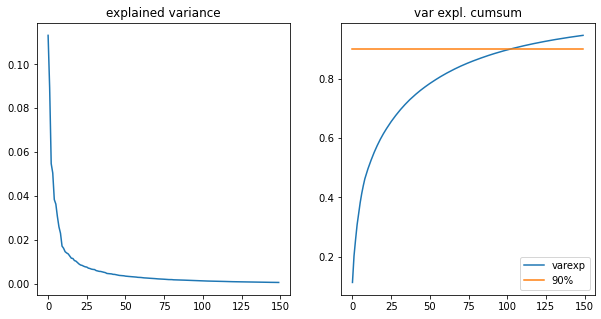

In [10]:
nplot = 150
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(reducer.explained_variance_ratio_[0:nplot])
plt.title('explained variance')
plt.subplot(1,2,2)
plt.plot(np.cumsum(reducer.explained_variance_ratio_[0:nplot]))
plt.plot(np.arange(nplot),np.repeat(.9,nplot))
plt.title('var expl. cumsum')
plt.legend(['varexp','90%'])

In [47]:
# LOSO PCA
est_pca = False
if est_pca:
    ns = flatmap.shape[0]
    j_pca_loso = np.array([PCA().fit(flatmap[np.arange(ns)!=s]).transform(flatmap[s,:][np.newaxis,:]) for s in tqdm(range(ns))])
    np.save(file='../../Data/j_pca_loso.npy',arr=j_pca_loso)
else:
    j_pca_loso = np.load('../../Data/j_pca_loso.npy')

j_pca_loso_2 = j_pca_loso[:,0,0:2]

In [49]:
j_pca = j_pca_loso_2

In [314]:
#j_pca = UMAP(n_components=2).fit_transform(flatmap)

In [315]:
#from scipy.stats import pearsonr
corr = kendalltau

In [316]:
jacobians_flat = np.array([im.numpy().flatten() for im in ims])

In [317]:
# DO X AXIS
res = np.array([corr(jacobians_flat[:,v],j_pca[:,0]) for v in tqdm(range(jacobians_flat.shape[1]))])
xcorr_r = res[:,0]
xcorr_p = res[:,1]

100%|██████████| 262144/262144 [00:51<00:00, 5096.34it/s]


In [318]:
# DO Y AXIS
res = np.array([corr(jacobians_flat[:,v],j_pca[:,1]) for v in tqdm(range(jacobians_flat.shape[1]))])
ycorr_r = res[:,0]
ycorr_p = res[:,1]

100%|██████████| 262144/262144 [00:51<00:00, 5125.48it/s]


In [319]:
# Runtime warning when correlating zero voxels, can ignore
#xcorr = np.array([np.corrcoef(jacobians_flat[:,v],j_pca[:,0])[0,1] for v in tqdm(range(jacobians_flat.shape[1]))])
#ycorr = np.array([np.corrcoef(jacobians_flat[:,v],j_pca[:,1])[0,1] for v in tqdm(range(jacobians_flat.shape[1]))])

In [322]:
# BONF CORRECT MAPS
xcorr_r_threshed = xcorr_r.copy()
ycorr_r_threshed = ycorr_r.copy()

p_thresh = .05/(~np.isnan(xcorr_p)).sum()

xcorr_r_threshed[xcorr_p>p_thresh]=np.nan
ycorr_r_threshed[ycorr_p>p_thresh]=np.nan

In [323]:
print((abs(xcorr_r_threshed[xcorr_p<p_thresh])).min())
print((abs(ycorr_r_threshed[ycorr_p<p_thresh])).min())

0.15162183005942928
0.15162183005942928


In [324]:
# plt.hist(xcorr_r_threshed[xcorr_p<p_thresh])
# plt.hist(ycorr_r_threshed[ycorr_p<p_thresh])

In [325]:
temp = ants.image_read('single_subj_T1.nii')
temp = temp.resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=1)

In [326]:
xcorr_nii = ims[0].new_image_like(xcorr_r_threshed.reshape((64,64,64))) #.plot_ortho(flat=True,black_bg=True,cmap='bwr')
ycorr_nii = ims[0].new_image_like(ycorr_r_threshed.reshape((64,64,64))) #.plot_ortho(flat=True,black_bg=True,cmap='bwr')

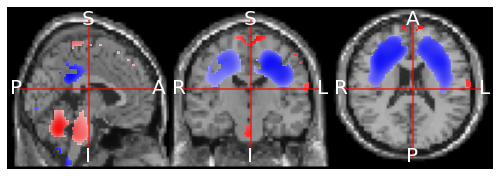

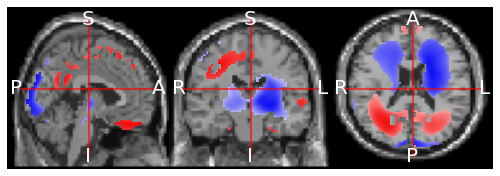

In [327]:
temp.plot_ortho(xcorr_nii,flat=True,black_bg=True,cmap='gray',overlay_cmap='bwr')
temp.plot_ortho(ycorr_nii,flat=True,black_bg=True,cmap='gray',overlay_cmap='bwr')

In [328]:
ycorr_r_threshed[np.isnan(ycorr_r_threshed)]=0
xcorr_r_threshed[np.isnan(xcorr_r_threshed)]=0

#ims[0].new_image_like(xcorr_r_threshed.reshape((64,64,64))).to_filename('xcorr-bonf.nii')
#ims[0].new_image_like(ycorr_r_threshed.reshape((64,64,64))).to_filename('ycorr-bonf.nii')

In [329]:
print(np.nanmin(xcorr_r).round(3),np.nanmean(xcorr_r).round(3),np.nanmax(xcorr_r).round(3))
print(np.nanmin(ycorr_r).round(3),np.nanmean(ycorr_r).round(3),np.nanmax(ycorr_r).round(3))

-0.419 -0.034 0.511
-0.418 -0.011 0.442


## CORRELATE PCA W/ SYMPTOMS

In [330]:
# CORR PCA W/ SYMOTOMS
corr = pearsonr
corr = kendalltau

keys = ['AgeAtScan','FIQ','ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh','ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB','ADI_R_Onset Total']
npcs = 2 # How many PCs
# Make dataframe
col1 = list()
col2 = list()
for key in keys:
    for i in ['r','p']:
        col1.append(key)
        col2.append(i)
#columns = [[key,key],['r','p']]
columns = [col1,col2]
res_corr = pd.DataFrame(np.zeros((npcs,len(col1))),columns=columns)

for key in keys:
    for pc in range(npcs):
        vec_behav = df[key].values[patients]
        vec_pca = j_pca_loso[:,0,pc]
        #vec_pca = j_pca[:,pc]
        e = np.isnan(vec_behav)
        r,p = corr(vec_behav[~e],vec_pca[~e])
        res_corr.loc[pc].at[(key,'r')] = r
        res_corr.loc[pc].at[(key,'p')] = p
        #res_corr.loc[pc].at[(key,'n')] = len(vec_behav[~e])

In [331]:
pd.options.display.max_columns = None
res_corr

AgeAtScan                 FIQ           ADOS_Comm           ADOS_Social  \
          r         p         r         p         r         p           r   
0  0.057140  0.064370  0.004525  0.889681  0.092896  0.017455    0.056288   
1  0.043463  0.159456  0.016245  0.618488  0.080827  0.038626   -0.042589   

            ADOS_StBeh           ADI_R_SocialTotal            \
          p          r         p                 r         p   
0  0.136015   0.098143  0.023156          0.042289  0.278463   
1  0.259333  -0.061405  0.155377         -0.023770  0.542405   

  ADI_R_VerbalTotal           ADI_R_RRB           ADI_R_Onset Total            
                  r         p         r         p                 r         p  
0          0.007433  0.849078 -0.043311  0.279294          0.021979  0.618564  
1          0.025932  0.506788 -0.010662  0.789983         -0.006015  0.891613

In [332]:
for pc in range(res_corr.shape[0]):
    for key in keys:
        p = res_corr[key]['p'][pc]
        if p < .05:
            print('PC {} - {} | r = {:.3f},p = {:.3f}'.format(pc,key,res_corr[key]['r'][pc],res_corr[key]['p'][pc]))

PC 0 - ADOS_Comm | r = 0.093,p = 0.017
PC 0 - ADOS_StBeh | r = 0.098,p = 0.023
PC 1 - ADOS_Comm | r = 0.081,p = 0.039


## GENE CORR

In [333]:
import os
gene_dir = '../../Data/gene_epression_maps/'
genefiles = os.listdir(gene_dir);genefiles.sort()
genefiles = np.array(genefiles)
ord_ = np.array([0, 8, 6, 10, 5, 3, 11, 9, 4, 7, 1, 2])
genefiles = genefiles[ord_]
ng = len(genefiles)
genefiles

array(['gene_1098_CHD2_1106.0.nii.gz', 'gene_36765_ARID1B_57492.0.nii.gz',
       'gene_30768_CHCHD8_51287.0.nii.gz',
       'gene_85618_SHANK2-AS3_220070.0.nii.gz',
       'gene_30427_SHANK1_50944.0.nii.gz',
       'gene_22696_SHANK2_22941.0.nii.gz',
       'gene_8754_SYNGAP1_8831.0.nii.gz',
       'gene_59528_SHANK3_85358.0.nii.gz',
       'gene_22881_POGZ_23126.0.nii.gz',
       'gene_35158_ASH1L_55870.0.nii.gz',
       'gene_150958_ASH1L-AS1_645676.0.nii.gz',
       'gene_1847_DYRK1A_1859.0.nii.gz'], dtype='<U37')

In [334]:
genemaps = [ants.image_read(os.path.join(gene_dir,genefile)) for genefile in genefiles]
genemaps = [genemap.resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=1) for genemap in genemaps]


In [335]:
xcorr_nii = ims[0].new_image_like(xcorr_r_threshed.reshape((64,64,64)))
ycorr_nii = ims[0].new_image_like(ycorr_r_threshed.reshape((64,64,64)))

In [336]:
genecorr_x = np.array([corr(genemap.flatten()[xcorr_nii.flatten()!=0],xcorr_nii.flatten()[xcorr_nii.flatten()!=0]) for genemap in genemaps])
genecorr_y = np.array([corr(genemap.flatten()[ycorr_nii.flatten()!=0],ycorr_nii.flatten()[ycorr_nii.flatten()!=0]) for genemap in genemaps])

In [337]:
# v1=genemaps[0].flatten()[xcorr_nii.flatten()!=0]
# v2=xcorr_nii.flatten()[xcorr_nii.flatten()!=0]
# slope, intercept, r_value, p_value, std_err = linregress(v1,v2)

def do_linreg(v1,v2):
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(v1,v2)
    return (r_value,p_value)

In [338]:
genecorr_x = np.array([do_linreg(genemap.flatten()[xcorr_nii.flatten()!=0],xcorr_nii.flatten()[xcorr_nii.flatten()!=0]) for genemap in genemaps])
genecorr_y = np.array([do_linreg(genemap.flatten()[ycorr_nii.flatten()!=0],ycorr_nii.flatten()[ycorr_nii.flatten()!=0]) for genemap in genemaps])

#genecorr_x = np.array([do_linreg(genemap.flatten(),xcorr_nii.flatten()) for genemap in genemaps])
#genecorr_y = np.array([do_linreg(genemap.flatten(),ycorr_nii.flatten()) for genemap in genemaps])

In [339]:
columns = [['X','X','Y','Y'],['r','p','r','p']]
res_genecorr = pd.DataFrame(
    data=np.hstack((genecorr_x,genecorr_y)),
    columns=columns,index=genefiles)
res_genecorr.round(4)

X               Y        
                                            r       p       r       p
gene_1098_CHD2_1106.0.nii.gz           0.2488  0.0000 -0.1447  0.0000
gene_36765_ARID1B_57492.0.nii.gz       0.1309  0.0000 -0.0562  0.0000
gene_30768_CHCHD8_51287.0.nii.gz       0.1386  0.0000 -0.1401  0.0000
gene_85618_SHANK2-AS3_220070.0.nii.gz  0.0991  0.0000  0.0348  0.0000
gene_30427_SHANK1_50944.0.nii.gz      -0.1384  0.0000  0.2887  0.0000
gene_22696_SHANK2_22941.0.nii.gz      -0.0961  0.0000  0.2252  0.0000
gene_8754_SYNGAP1_8831.0.nii.gz       -0.2282  0.0000  0.1315  0.0000
gene_59528_SHANK3_85358.0.nii.gz      -0.0121  0.0803 -0.0905  0.0000
gene_22881_POGZ_23126.0.nii.gz         0.0967  0.0000 -0.1162  0.0000
gene_35158_ASH1L_55870.0.nii.gz       -0.0620  0.0000  0.0237  0.0009
gene_150958_ASH1L-AS1_645676.0.nii.gz -0.0071  0.3004 -0.0078  0.2743
gene_1847_DYRK1A_1859.0.nii.gz         0.0331  0.0000  0.0909  0.0000

In [340]:
genes_flat = np.array([genemap.flatten()[evox] for genemap in genemaps])

In [341]:
from sklearn.linear_model import LinearRegression

In [342]:
import numpy as np
import statsmodels.api as sm
def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

In [343]:
print(reg_m(np.e**flatmap[10,:], genes_flat).summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     110.6
Date:                Mon, 07 Feb 2022   Prob (F-statistic):          1.29e-273
Time:                        13:10:06   Log-Likelihood:                 26143.
No. Observations:               55432   AIC:                        -5.226e+04
Df Residuals:                   55419   BIC:                        -5.214e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0076      0.002     -3.360      0.0

In [344]:
xreg = reg_m(ycorr_nii.flatten()[evox], np.e**genes_flat)
print(xreg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     143.5
Date:                Mon, 07 Feb 2022   Prob (F-statistic):               0.00
Time:                        13:10:08   Log-Likelihood:                 29270.
No. Observations:               55432   AIC:                        -5.851e+04
Df Residuals:                   55419   BIC:                        -5.840e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0023      0.001      2.949      0.0

In [345]:
yreg = reg_m(xcorr_nii.flatten()[evox], np.e**genes_flat)
print(yreg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     103.7
Date:                Mon, 07 Feb 2022   Prob (F-statistic):          5.07e-256
Time:                        13:10:08   Log-Likelihood:                 24798.
No. Observations:               55432   AIC:                        -4.957e+04
Df Residuals:                   55419   BIC:                        -4.945e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0024      0.001      2.795      0.0

In [346]:
yreg.rsquared

0.021954054603762985

In [347]:
xreg.rsquared

0.030137637226883673

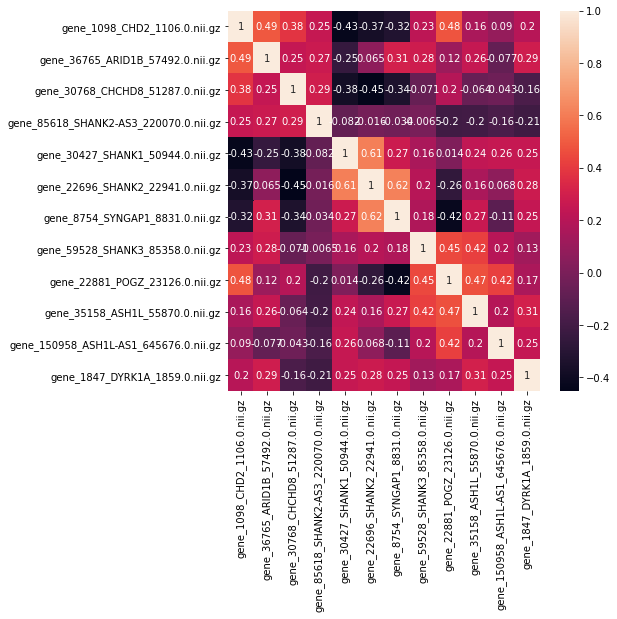

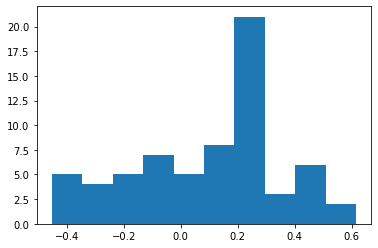

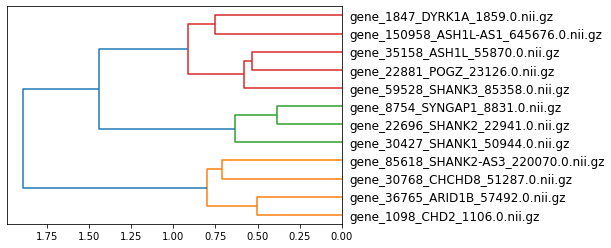

In [289]:
from scipy.cluster.hierarchy import linkage,dendrogram
gcmat = np.corrcoef(genes_flat)
gcvec = gcmat[np.triu_indices(gcmat.shape[0],1)]

plt.figure(figsize=(7,7))
sns.heatmap(gcmat,annot=True,xticklabels=genefiles,yticklabels=genefiles)

plt.figure()
plt.hist(gcvec)

plt.figure()
res = dendrogram(linkage(1-gcvec,'ward'),0,labels=genefiles,orientation='left')

In [290]:
print(now())

2022-02-07 13:02:02.818436
